In [1]:
%matplotlib widget

import time
from pacti.terms.polyhedra import *
from pacti_instrumentation.pacti_counters import summarize_instrumentation_data
import numpy as np
from contract_utils import *
from generators import *

from p_tqdm import p_umap
from scipy.stats import qmc

import pickle

This notebook demonstrates generating scenarios by varying the hyper-parameters of specific system functions (`dsn`, `chrg`, `sbo`, `tcm_h`, and `tcm_db`) as described below:

In [2]:
# lower bounds for design hyperparameters
l_bounds = [
    2.0,  # power: min dns cons
    2.5,  # power: min chrg gen
    0.3,  # power: min sbo cons
    0.2,  # power: min tcm_h cons
    0.1,  # power: min tcm_dv cons
    5.0,  # science: min dsn speed
    2.0,  # science: min sbo gen
    1.0,  # nav: min dsn noise
    1.0,  # nav: min chrg noise
    0.5,  # nav: min sbo imp
    1.2,  # nav: min tcm_dv noise
    0.3,  # nav: min tcm_dv progress
]
# upper bounds for design hyperparameters
u_bounds = [
    2.2,  # power: max dns cons
    3.5,  # power: max chrg gen
    0.4,  # power: max sbo cons
    0.3,  # power: max tcm_h cons
    0.2,  # power: max tcm_dv cons
    6.0,  # science: max dsn speed
    8.0,  # science: max sbo gen
    1.2,  # nav: max dsn noise
    1.2,  # nav: max chrg noise
    0.8,  # nav: max sbo imp
    1.4,  # nav: max tcm_dv noise
    0.5,  # nav: max tcm_dv progress
]

We use the Latin Hypercube sampler to generate `n20` random combinations of hyper-parameters. We exploit as much parallelism as available on the machine to generate 20-step scenarios for each combination, which requires creating 115 contracts combined via 63 contract composition and 50 contract merge operations. The results show that Pacti's operations for constructing contracts scale very well. 

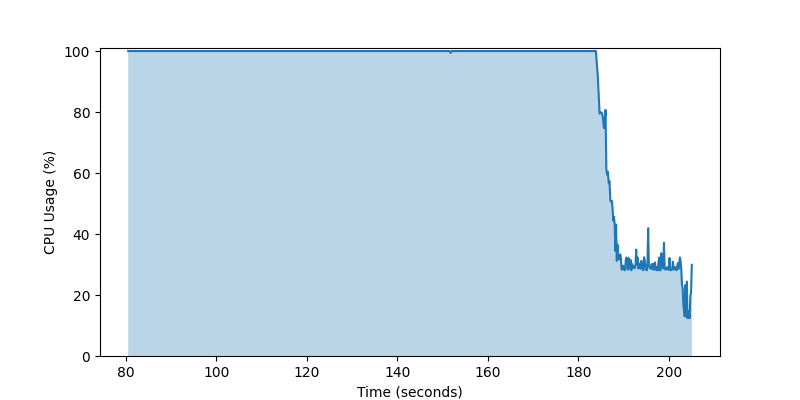

Output()

Generated 200 hyperparameter variations of the 20-step scenario in 205.13866472244263 seconds.
Running on AMD Ryzen Threadripper PRO 3955WX 16-Cores @ 3.8927 GHz with up to 32 threads.
Pacti compose,quotient,merge statistics:
compose invocation counts: (min: 51, max: 51, avg: 51.0, total: 10200)
min/max compose contract size: (constraints: 6, variables: 3)/(constraints: 185, variables: 95)
no quotient operations
merge invocation counts: (min: 40, max: 40, avg: 40.0, total: 8000)
min/max merge contract size: (constraints: 3, variables: 2)/(constraints: 45, variables: 23)
Pacti PolyhedralTermList statistics:
no contains_behavior operations
Pacti PolyhedralCompoundContract statistics:
no compound_merge operations



In [3]:
mean_sampler = qmc.LatinHypercube(d=len(l_bounds))
dev_sampler = qmc.LatinHypercube(d=len(l_bounds))

n20 = 200
mean_sample20: np.ndarray = mean_sampler.random(n=n20)
scaled_mean_sample20: np.ndarray = qmc.scale(sample=mean_sample20, l_bounds=l_bounds, u_bounds=u_bounds)
dev_sample20: np.ndarray = dev_sampler.random(n=n20)

nb_20step_operations = OperationCounts(contracts=115, compositions=63, merges=50)

from pacti_instrumentation.cpu_usage_plot import cpu_usage_plot
with cpu_usage_plot(max_data_points=500, finally_clear_output=True):
    ta = time.time()
    results: List[Tuple[PactiInstrumentationData, List[tuple2float], PolyhedralContract]] = p_umap(generate_20step_scenario, list(zip(scaled_mean_sample20, dev_sample20)))
    tb = time.time()


stats = summarize_instrumentation_data([result[0] for result in results])
scenarios20 = [result[1:3] for result in results if result[1]]

print(
    f"Generated {n20} hyperparameter variations of the 20-step scenario in {tb-ta} seconds.\n"
    f"Running on {cpu_info_message}\n"
    f"{stats.stats()}"
)
s = open("scenarios20.data", "wb")
pickle.dump(scenarios20, s)
s.close()
